In [2]:
import jax
import jax.numpy as jnp
import inspeqtor.experimental as sq
from inspeqtor.legacy import visualization as vis

import qutip
from functools import partial
import matplotlib.pyplot as plt

import scienceplots  # noqa: F401

In [ ]:
import typing

def detune_x(params, t):
    return 0.001

def rotating_transmon_hamiltonian(
    params: sq.typing.HamiltonianArgs,
    t: jnp.ndarray,
    qubit_info: sq.data.QubitInformation,
    signal: typing.Callable[[sq.typing.HamiltonianArgs, jnp.ndarray], jnp.ndarray],
    # detune_x: float = 0.0,
) -> jnp.ndarray:
    """Rotating frame hamiltonian of the transmon model

    Args:
        params (HamiltonianParameters): The parameter of the pulse for hamiltonian
        t (jnp.ndarray): The time to evaluate the Hamiltonian
        qubit_info (QubitInformation): The information of qubit
        signal (Callable[..., jnp.ndarray]): The pulse signal

    Returns:
        jnp.ndarray: The Hamiltonian
    """
    a0 = 2 * jnp.pi * qubit_info.frequency
    a1 = 2 * jnp.pi * qubit_info.drive_strength

    def f3(params, t):
        return a1 * signal(params, t)

    def f_sigma_x(params, t):
        return f3(params, t) * jnp.cos(a0 * t)

    def f_sigma_y(params, t):
        return f3(params, t) * jnp.sin(a0 * t)

    return (
        (f_sigma_x(params, t)) * sq.constant.X
        - f_sigma_y(params, t) * sq.constant.Y
        # + detune_x * sq.constant.X
    )

In [52]:
qubit_info = sq.predefined.get_mock_qubit_information()
pulse_sequence = sq.predefined.get_gaussian_pulse_sequence(qubit_info)
# pulse_sequence = sq.predefined.get_drag_pulse_v2_sequence(qubit_info)
dt = 2 / 9
angle = 0 # jnp.pi / 2
# angle = 0.01

t_eval = jnp.linspace(
    0,
    pulse_sequence.pulse_length_dt * dt,
    pulse_sequence.pulse_length_dt,
)

array_to_list_of_params_fn, list_of_params_to_array_fn = (
    sq.pulse.get_param_array_converter(pulse_sequence)
)

hamiltonian = partial(
    sq.predefined.rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=sq.physics.signal_func_v5(
        get_envelope=sq.predefined.get_envelope_transformer(
            pulse_sequence=pulse_sequence
        ),
        drive_frequency=qubit_info.frequency,
        dt=dt,
    ),
)

# hamiltonian = sq.utils.detune_hamiltonian(hamiltonian, 0.0000 * qubit_info.frequency)

whitebox = partial(
    sq.physics.solver,
    t_eval=t_eval,
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex64),
    t0=0,
    t1=pulse_sequence.pulse_length_dt * dt,
)

whitebox = sq.physics.make_trotterization_whitebox(
    hamiltonian=hamiltonian,
    pulse_sequence=pulse_sequence,
    dt=dt,
)

params: list[sq.typing.ParametersDictType] = [
    {
        "theta": jnp.array(angle), 
        # "beta": jnp.array(1.0)
    }
]
unitary = whitebox(list_of_params_to_array_fn(params))
baseline_expvals = sq.utils.calculate_expectation_values(unitary).T

detune = .001  # * qubit_info.frequency

hamiltonian = partial(
    rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=sq.physics.signal_func_v5(
        get_envelope=sq.predefined.get_envelope_transformer(
            pulse_sequence=pulse_sequence
        ),
        drive_frequency=qubit_info.frequency, #* (1 + detune),
        dt=dt,
    ),
    # detune_x=detune
)

# hamiltonian = sq.utils.detune_hamiltonian(hamiltonian, detune)
# hamiltonian = detune_x_hamiltonian(hamiltonian, detune)

whitebox = partial(
    sq.physics.solver,
    t_eval=t_eval,
    hamiltonian=hamiltonian,
    y0=jnp.eye(2, dtype=jnp.complex64),
    t0=0,
    t1=pulse_sequence.pulse_length_dt * dt,
)

# whitebox = sq.physics.make_trotterization_whitebox(
#     hamiltonian=hamiltonian,
#     pulse_sequence=pulse_sequence,
#     dt=dt,
# )

params: list[sq.typing.ParametersDictType] = [
    {
        "theta": jnp.array(angle), 
        # "beta": jnp.array(1.0)
    }
]
unitary = whitebox(list_of_params_to_array_fn(params))
detuned_expvals = sq.utils.calculate_expectation_values(unitary).T

In [53]:
list_of_params_to_array_fn(params)

Array([0], dtype=int64)

(<Figure size 2000x1000 with 1 Axes>,
 <Axes: xlabel='Time (dt)', ylabel='Amplitude'>)

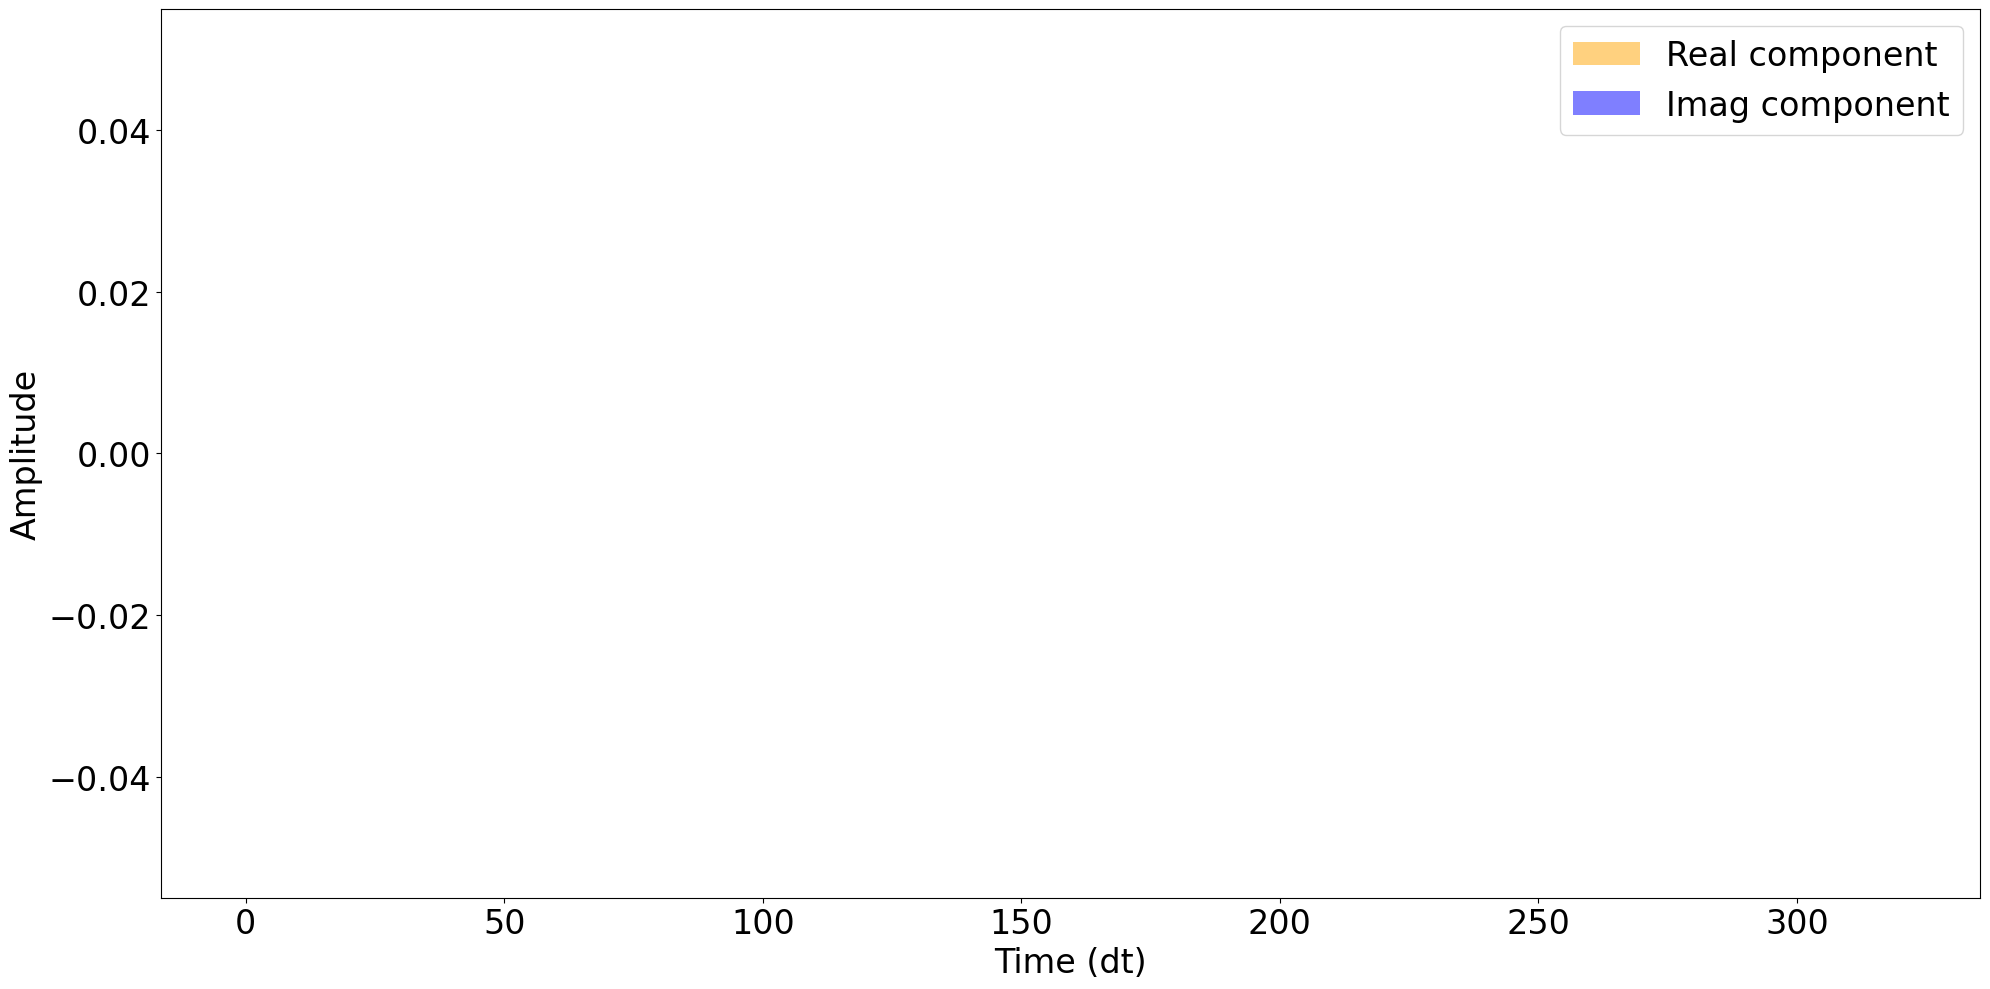

In [54]:
vis.draw_complex_pulse(
    pulse_sequence.get_waveform(params),
    jnp.arange(pulse_sequence.pulse_length_dt),
    font_size=24,
)

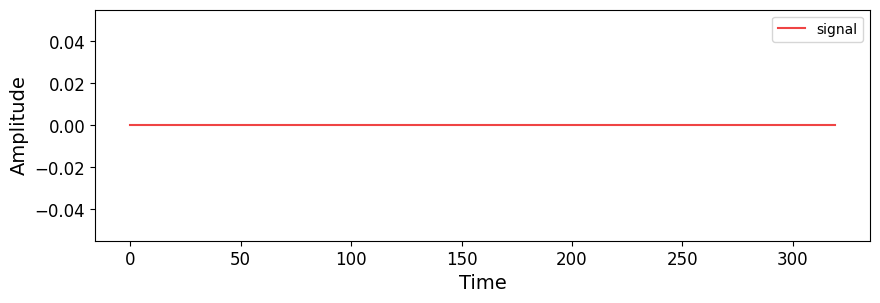

In [56]:
signal = jax.vmap(
    sq.physics.signal_func_v5(
        get_envelope=pulse_sequence.get_envelope,
        drive_frequency=qubit_info.frequency,
        dt=2 / 9,
    ),
    in_axes=(None, 0),
)(params, t_eval)

fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(signal, label="signal", color="#ef4444")
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend()

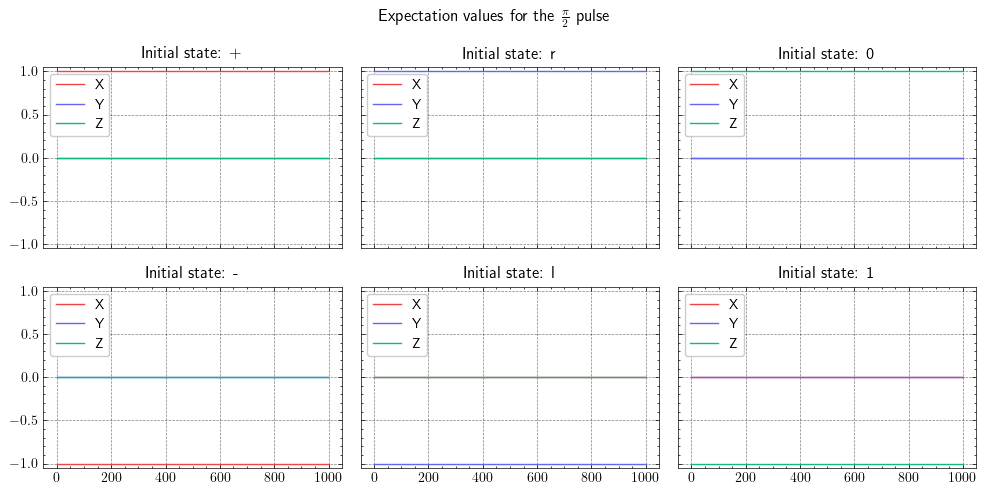

In [57]:
with plt.style.context(["science", "grid"]):
    fig, axes = sq.visualization.plot_expectation_values(
        sq.visualization.format_expectation_values(baseline_expvals),
        r"Expectation values for the $\frac{\pi}{2}$ pulse",
    )

In [58]:
detune * 100 / qubit_info.frequency

0.02

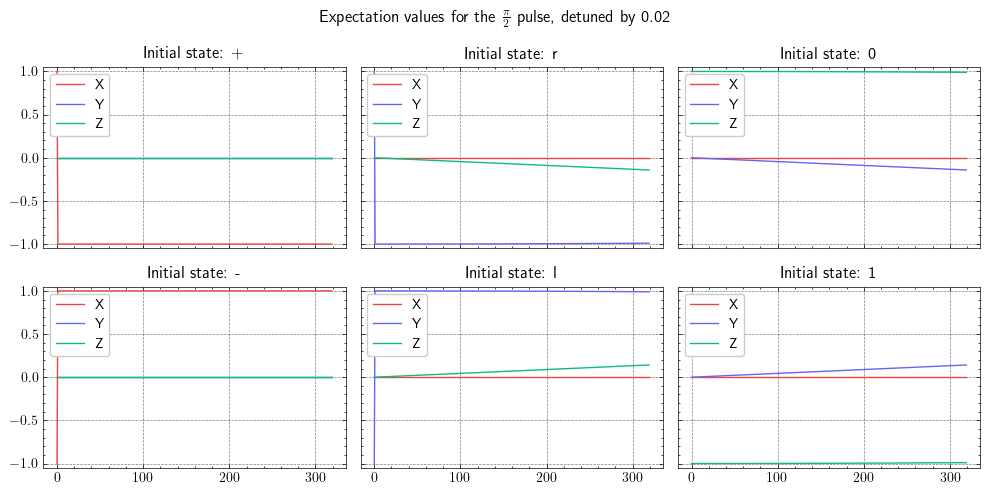

In [59]:
with plt.style.context(["science", "grid"]):
    title = r"Expectation values for the $\frac{\pi}{2}$ pulse"
    title += (
        f", detuned by {detune * 100 / qubit_info.frequency}% of the qubit frequency"
    )
    _ = sq.visualization.plot_expectation_values(
        sq.visualization.format_expectation_values(detuned_expvals),
        title,
    )

In [41]:
formtted_detune_expval = sq.visualization.format_expectation_values(detuned_expvals)

In [31]:
(formtted_detune_expval["0"]["X"][-1] + 1) / 2

Array(0.50025348, dtype=float64)

In [32]:
(formtted_detune_expval["0"]["Z"][-1] + 1) / 2

Array(0.42913348, dtype=float64)

In [33]:
(formtted_detune_expval["0"]["Y"][-1] + 1) / 2

Array(0.00504761, dtype=float64)

In [9]:
# For pi / 2 pulse
# The Phase flip error is
phase_flip_error_rate = (
    formtted_detune_expval["+"]["X"][-1] + 1
) / 2 - 1  # NOTE: -1 because the compare to the ideal
# The Bit flip error is
bit_flip_error_rate = (
    formtted_detune_expval["0"]["Z"][-1] + 1
) / 2 - 0.5  # NOTE: 0.5 because the compare to the ideal
# Both
both_flip_error_rate = (formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5

# Interesting value,
print(f"The error rate is {both_flip_error_rate * 100:.2f}%")
print(f"The error rate is {bit_flip_error_rate * 100: .2f}%")
print(f"The error rate is {phase_flip_error_rate * 100: .2f}%")
jnp.abs((formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5) + (
    (formtted_detune_expval["0"]["Z"][-1] + 1) / 2 - 0.5
)

The error rate is 40.38%
The error rate is  3.11%
The error rate is -38.49%


Array(0.4348694, dtype=float64)

In [18]:
# For pi pulse
# The Phase flip error is
phase_flip_error_rate = (
    formtted_detune_expval["+"]["X"][-1] + 1
) / 2 - 1  # NOTE: -1 because the compare to the ideal
# The Bit flip error is
bit_flip_error_rate = (
    formtted_detune_expval["0"]["Z"][-1] + 1
) / 2 - 0.0  # NOTE: 0.0 because the compare to the ideal
# Both
both_flip_error_rate = (formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.0

# Interesting value,
print(f"The error rate is {both_flip_error_rate * 100:.2f}%")
print(f"The error rate is {bit_flip_error_rate * 100:.2f}%")
print(f"The error rate is {phase_flip_error_rate * 100:.2f}%")
jnp.abs((formtted_detune_expval["r"]["Y"][-1] + 1) / 2 - 0.5) + (
    (formtted_detune_expval["0"]["Z"][-1] + 1) / 2 - 0.5
)

The error rate is 75.69%
The error rate is 6.69%
The error rate is -81.76%


Array(-0.17625415, dtype=float64)

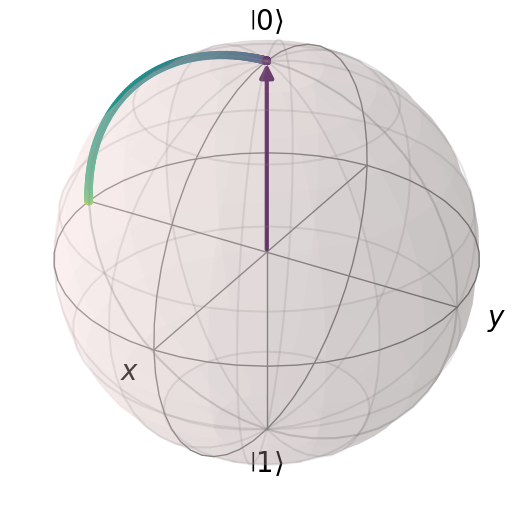

In [ ]:
b = qutip.Bloch()

formatted_expval = sq.visualization.format_expectation_values(baseline_expvals)

viridis = plt.get_cmap("viridis", 320)
colors = viridis(range(320))

b.add_states(qutip.basis(2, 0), colors="#3e0751")

b.add_points(
    jnp.vstack(
        [
            formatted_expval["0"]["X"],
            formatted_expval["0"]["Y"],
            formatted_expval["0"]["Z"],
        ]
    ),
    meth="m",
    colors=colors,
)

# b.add_points(jnp.vstack(
#     [
#         formatted_expval["r"]["X"],
#         formatted_expval["r"]["Y"],
#         formatted_expval["r"]["Z"],
#     ]
# ))

b.show()